In [1]:
#!pip install shapely
import json
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage.feature import canny
from collections import defaultdict
from PIL import Image
from skimage.color import rgba2rgb, rgb2gray
from skimage.feature import local_binary_pattern
from itertools import combinations
from shapely.geometry import box
from shapely.geometry.polygon import Polygon

matplotlib.rcParams['font.family'] = 'Times New Roman'

## Cantidad de fotos por set

In [2]:
directorio = './images'

In [3]:
cantidad_fotos = 0

for filename in os.listdir(directorio):
    if filename.endswith('.png'):
        cantidad_fotos += 1

print(f"La carpeta '{directorio}' contiene {cantidad_fotos} fotos.")

La carpeta './images' contiene 2000 fotos.


In [4]:
fotos_por_set = defaultdict(int)

for filename in os.listdir(directorio):
    if filename.endswith('.png'):
        numero_set = filename.split('_')[0]
        fotos_por_set[numero_set] += 1

# print("Frecuencia de fotos por set:")
# for numero_set, cantidad in fotos_por_set.items():
#     print(f"Set {numero_set}: {cantidad} fotos")

In [5]:
df = pd.read_csv('layoutsWithTags.csv')
numeros_de_sets_csv = df['layout_id'].unique()

def verificar_coincidencia(numero_set_csv):
    return str(numero_set_csv) in fotos_por_set

df['coincidencia'] = df['layout_id'].apply(verificar_coincidencia)
df_coincidentes = df[df['coincidencia']]

df_coincidentes.to_csv('layoutsWithTags.csv', index=False)

print(f"Se han guardado {len(df_coincidentes)} casos coincidentes en 'layoutsWithTags_coincidentes.csv'.")

Se han guardado 100 casos coincidentes en 'layoutsWithTags_coincidentes.csv'.


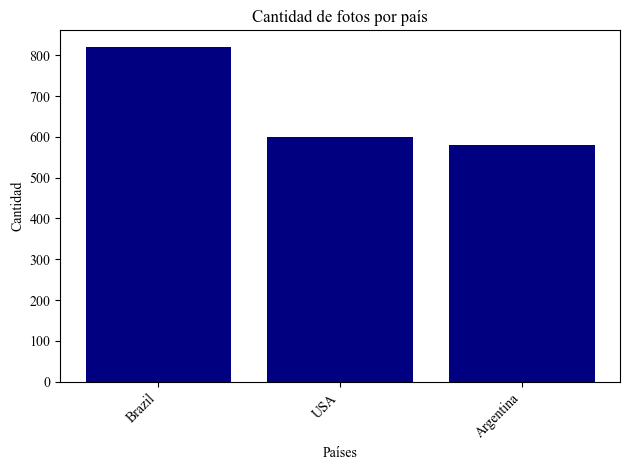

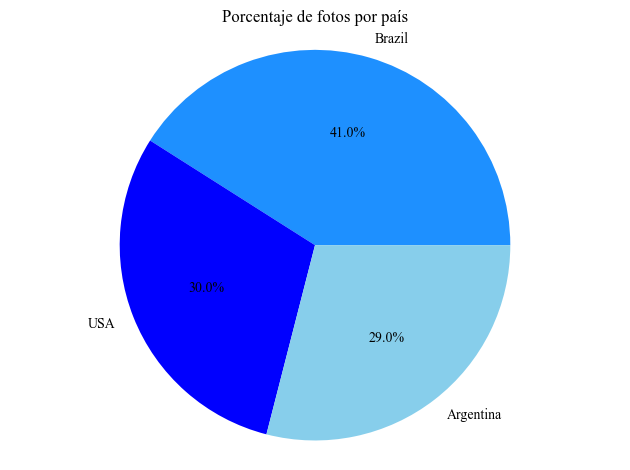

In [6]:
conteo_paises = df['country'].value_counts()

conteo_paises_multiplicado = conteo_paises * 20 # Dado que cada set tiene 20 fotos

plt.bar(conteo_paises_multiplicado.index, conteo_paises_multiplicado.values, color='navy')
plt.xlabel('Países')
plt.ylabel('Cantidad')
plt.title('Cantidad de fotos por país')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.pie(conteo_paises_multiplicado, labels=conteo_paises_multiplicado.index, autopct='%1.1f%%', colors=['dodgerblue', 'blue', 'skyblue'])
plt.title('Porcentaje de fotos por país')
plt.axis('equal')  
plt.tight_layout()
plt.show()

## Etiquetas

In [7]:
sin_etiquetas = df['relevant (new) tags'].isnull().sum()
fotos_sin_etiquetas = sin_etiquetas * 20

print(f"Total de filas sin etiquetas: {sin_etiquetas}")
print(f"Total de fotos sin etiquetas: {fotos_sin_etiquetas}")

Total de filas sin etiquetas: 0
Total de fotos sin etiquetas: 0


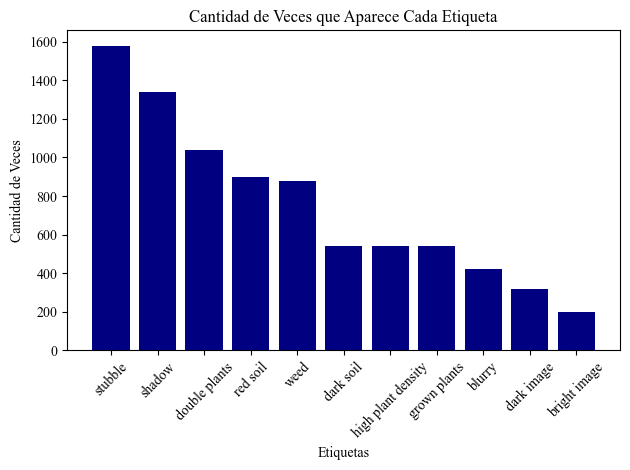

In [8]:
etiquetas_claves = {
    'dark soil': 1,
    'red soil': 2,
    'high plant density': 3,
    'shadow': 4,
    'stubble': 5,
    'weed': 6,
    'blurry': 7,
    'dark image': 8,
    'bright image': 9,
    'grown plants': 10,
    'double plants': 11
}

numeros = df['relevant (new) tags'].str.split(',')

todos_los_numeros = []
for sublist in numeros.dropna():
    for numero in sublist:
        if numero.strip():  # Ignorar valores vacíos
            todos_los_numeros.append(int(numero))

conteo_numeros = pd.Series(todos_los_numeros).value_counts()

conteo_numeros = conteo_numeros.sort_values(ascending=False)

etiquetas = [list(etiquetas_claves.keys())[list(etiquetas_claves.values()).index(num)] for num in conteo_numeros.index]

plt.bar(etiquetas, (conteo_numeros.values*20), color='navy')
plt.xlabel('Etiquetas')
plt.ylabel('Cantidad de Veces')
plt.title('Cantidad de Veces que Aparece Cada Etiqueta')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Datos generales

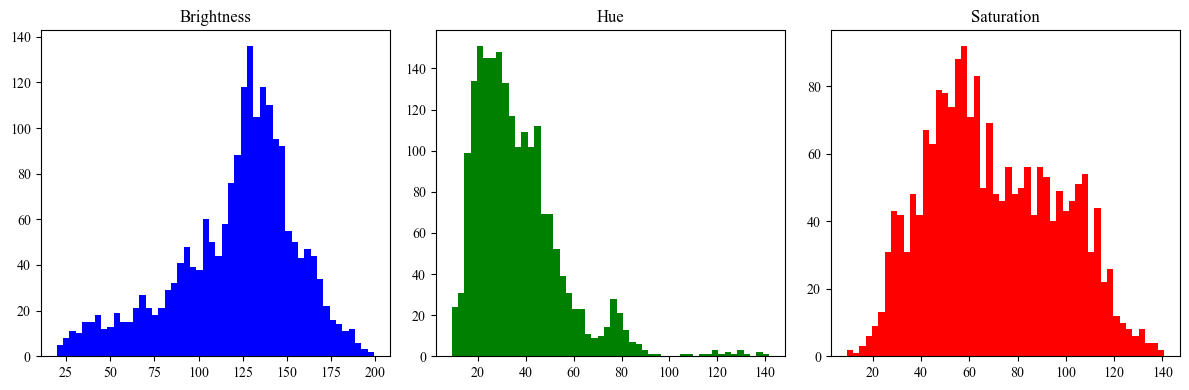

Las 3 imágenes con los valores más bajos de brillo:
Las 3 imágenes con los valores más altos de brillo:
Las 3 imágenes con los valores más bajos de matiz:
Las 3 imágenes con los valores más altos de matiz:
Las 3 imágenes con los valores más bajos de saturación:
Las 3 imágenes con los valores más altos de saturación:
Las 3 imágenes en el centro del espectro de matiz:


In [9]:
def extract_features(image):
    hsv_image = image.convert('HSV')
    h, s, v = hsv_image.split()
    brightness = np.mean(np.array(v))
    hue = np.mean(np.array(h))
    saturation = np.mean(np.array(s))
    
    return brightness, hue, saturation

def analyze_images(folder_path):
    brightness_values = []
    hue_values = []
    saturation_values = []
    images = []
    
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if os.path.isfile(image_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = Image.open(image_path)
            brightness, hue, saturation = extract_features(image)
            brightness_values.append(brightness)
            hue_values.append(hue)
            saturation_values.append(saturation)
            images.append(image)
    
    return brightness_values, hue_values, saturation_values, images

if __name__ == "__main__":
    folder_path = "images"
    
    brightness_values, hue_values, saturation_values, images = analyze_images(folder_path)
    
    # Histogramas
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(brightness_values, bins=50, color='b')
    plt.title('Brightness')
    plt.subplot(1, 3, 2)
    plt.hist(hue_values, bins=50, color='g')
    plt.title('Hue')
    plt.subplot(1, 3, 3)
    plt.hist(saturation_values, bins=50, color='r')
    plt.title('Saturation')
    plt.tight_layout()
    plt.show()
    
    low_brightness_indices = np.argsort(brightness_values)[:3]
    high_brightness_indices = np.argsort(brightness_values)[-3:]
    
    low_hue_indices = np.argsort(hue_values)[:3]
    high_hue_indices = np.argsort(hue_values)[-3:]
    
    low_saturation_indices = np.argsort(saturation_values)[:3]
    high_saturation_indices = np.argsort(saturation_values)[-3:]
    
    print("Las 3 imágenes con los valores más bajos de brillo:")
    for index in low_brightness_indices:
        images[index].show()
    
    print("Las 3 imágenes con los valores más altos de brillo:")
    for index in high_brightness_indices:
        images[index].show()
    
    print("Las 3 imágenes con los valores más bajos de matiz:")
    for index in low_hue_indices:
        images[index].show()
    
    print("Las 3 imágenes con los valores más altos de matiz:")
    for index in high_hue_indices:
        images[index].show()
    
    print("Las 3 imágenes con los valores más bajos de saturación:")
    for index in low_saturation_indices:
        images[index].show()
    
    print("Las 3 imágenes con los valores más altos de saturación:")
    for index in high_saturation_indices:
        images[index].show()
    
    median_hue = np.median(hue_values)
    central_hue_indices = np.argsort(np.abs(np.array(hue_values) - median_hue))[:3]
    
    print("Las 3 imágenes en el centro del espectro de matiz:")
    for index in central_hue_indices:
        images[index].show()


# Ancho y Alto de imagenes

In [10]:
file_path = "./merged_file.json"

with open(file_path, 'r') as file:
    json_data = file.read()
    
data = json.loads(json_data)


In [11]:

width_list = []
height_list = []

for item in data:
    for slot in item['item']['slots']:
        width_list.append(slot['width'])
        height_list.append(slot['height'])

# print("Width List:", width_list)
# print("Height List:", height_list)

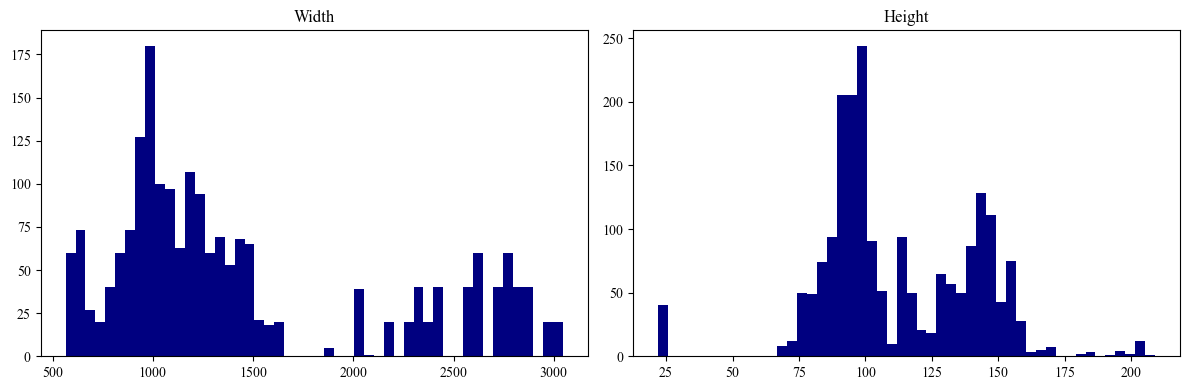

In [12]:
# plot histogram of width and height
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(width_list, bins=50, color='navy')
plt.title('Width')
plt.subplot(1, 2, 2)
plt.hist(height_list, bins=50, color='navy')
plt.title('Height')
plt.tight_layout()
plt.show()

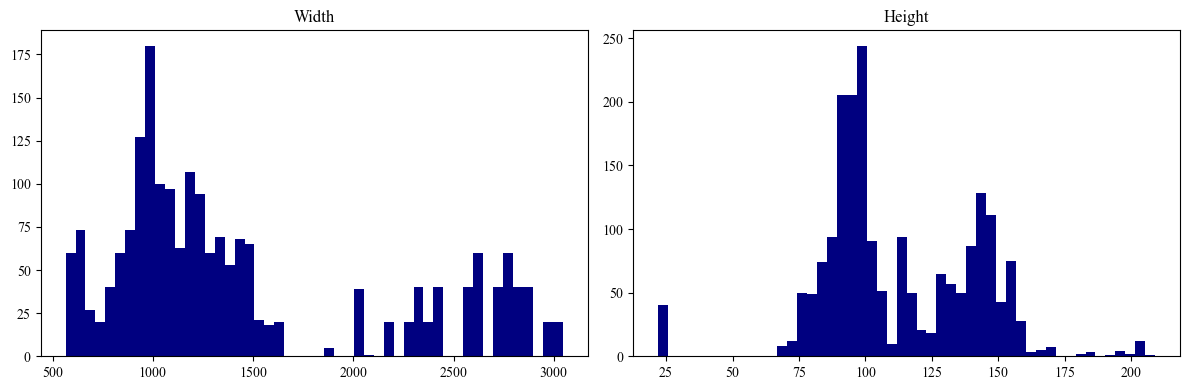

In [13]:
def extract_features(image):
    hsv_image = image.convert('HSV')
    h, s, v = hsv_image.split()
    brightness = np.mean(np.array(v))
    hue = np.mean(np.array(h))
    saturation = np.mean(np.array(s))
    width, height = image.size
    
    return brightness, hue, saturation, width, height

def analyze_images(folder_path):
    brightness_values = []
    hue_values = []
    saturation_values = []
    width_list = []
    height_list = []
    images = []
    
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if os.path.isfile(image_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = Image.open(image_path)
            brightness, hue, saturation, width, height = extract_features(image)
            brightness_values.append(brightness)
            hue_values.append(hue)
            saturation_values.append(saturation)
            width_list.append(width)
            height_list.append(height)
            images.append(image)
    
    return brightness_values, hue_values, saturation_values, width_list, height_list, images

if __name__ == "__main__":
    folder_path = "images"
    
    brightness_values, hue_values, saturation_values, width_list, height_list, images = analyze_images(folder_path)
    
    # Histogramas de anchura y altura
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(width_list, bins=50, color='navy')
    plt.title('Width')
    plt.subplot(1, 2, 2)
    plt.hist(height_list, bins=50, color='navy')
    plt.title('Height')
    plt.tight_layout()
    plt.show()
    

In [14]:
    # Muestra las 3 imágenes más anchas y más estrechas
widest_indices = np.argsort(width_list)[-3:]
narrowest_indices = np.argsort(width_list)[:3]

In [15]:
print("Las 3 imágenes más anchas:")
for index in widest_indices:
    images[index].show()
    

Las 3 imágenes más anchas:


In [16]:
print("Las 3 imágenes más estrechas:")
for index in narrowest_indices:
    images[index].show()

Las 3 imágenes más estrechas:


In [17]:
# Muestra las 3 imágenes más largas y más cortas
tallest_indices = np.argsort(height_list)[-3:]
shortest_indices = np.argsort(height_list)[:3]

In [18]:
print("Las 3 imágenes más altas:")
for index in tallest_indices:
    images[index].show()

Las 3 imágenes más altas:


In [19]:
print("Las 3 imágenes más bajas:")
for index in shortest_indices:
     images[index].show()


Las 3 imágenes más bajas:


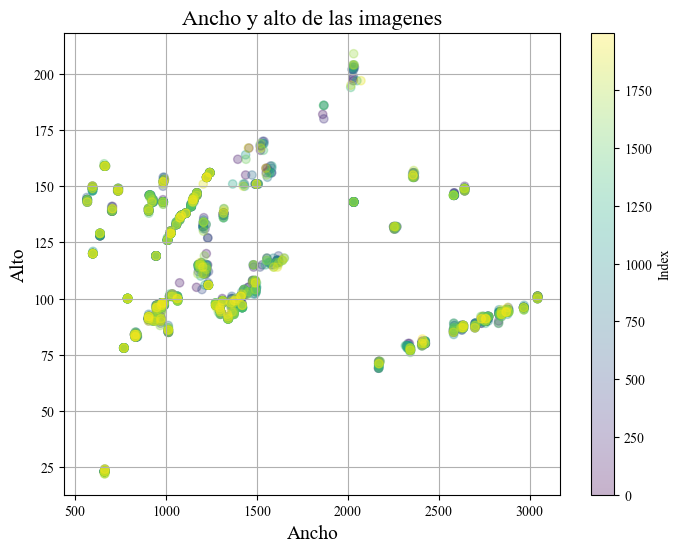

In [20]:
colors = range(len(width_list))
plt.figure(figsize=(8, 6))
plt.scatter(width_list, height_list, c=colors, cmap='viridis', alpha=0.3)
plt.colorbar(label='Index')
plt.title('Ancho y alto de las imagenes', fontsize=16)
plt.xlabel('Ancho', fontsize=14)
plt.ylabel('Alto', fontsize=14)
plt.grid(True)
plt.show()

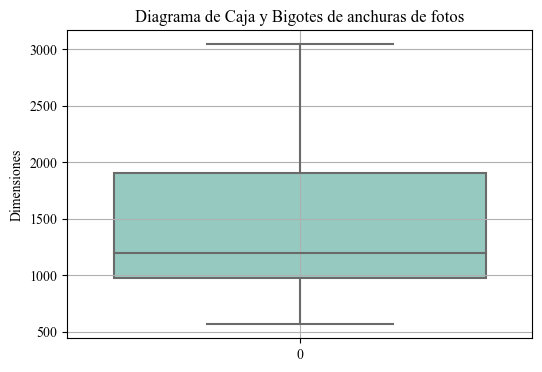

In [21]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=width_list, palette='Set3')
plt.title('Diagrama de Caja y Bigotes de anchuras de fotos')
plt.ylabel('Dimensiones')
plt.grid(True)
plt.show()

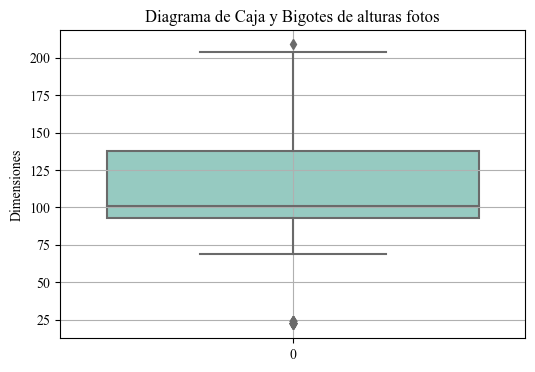

In [22]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=height_list, palette='Set3')
plt.title('Diagrama de Caja y Bigotes de alturas fotos')
plt.ylabel('Dimensiones')
plt.grid(True)
plt.show()

# Bounding Boxes

In [23]:
bounding_box_widths = []
bounding_box_heights = []
bounding_box_counts = []
category_counts = {}

for item in data:
    annotations = item.get('annotations', [])
    bounding_box_counts.append(len(annotations))  # Cantidad de bounding boxes por imagen
    for annotation in annotations:
        bounding_box = annotation.get('bounding_box', {})
        bounding_box_widths.append(bounding_box.get('w', 0))
        bounding_box_heights.append(bounding_box.get('h', 0))
        category = annotation.get('name', 'Unknown')
        category_counts[category] = category_counts.get(category, 0) + 1

A continuación mostramos las imagenes que no poseen boundig boxes

In [24]:
import os

no_annotations_count = 0

for item in data:
    annotations = item.get('annotations', [])
    if not annotations:  # Si la lista de anotaciones está vacía
        no_annotations_count += 1
        item_name = item['item']['name']
        print(f"Item sin anotaciones: {item_name}")
        image_name = item_name
        image_path = os.path.join(directorio, image_name)
        if os.path.exists(image_path):
            print(f"Imagen encontrada: {image_path}")
        else:
            print(f"La imagen no se encuentra en la carpeta de imágenes.")

if no_annotations_count == 0:
    print("Todos los elementos tienen al menos una anotación.")
else:
    print(f"Hay {no_annotations_count} elementos sin anotaciones.")


Item sin anotaciones: 54120_16-31-1-1.png
Imagen encontrada: ./images/54120_16-31-1-1.png
Item sin anotaciones: 3177_149-10-1-3.png
Imagen encontrada: ./images/3177_149-10-1-3.png
Item sin anotaciones: 53855_30-8-1-3.png
Imagen encontrada: ./images/53855_30-8-1-3.png
Item sin anotaciones: 54189_24-1-1-3.png
Imagen encontrada: ./images/54189_24-1-1-3.png
Item sin anotaciones: 34246_15-2-1-2.png
Imagen encontrada: ./images/34246_15-2-1-2.png
Item sin anotaciones: 53824_35-37-1-2.png
Imagen encontrada: ./images/53824_35-37-1-2.png
Item sin anotaciones: 6740_3-5-1-1.png
Imagen encontrada: ./images/6740_3-5-1-1.png
Item sin anotaciones: 33253_10-4-1-1.png
Imagen encontrada: ./images/33253_10-4-1-1.png
Item sin anotaciones: 53855_10-3-1-2.png
Imagen encontrada: ./images/53855_10-3-1-2.png
Hay 9 elementos sin anotaciones.


Hay alguna imagen en el jason que no esté en la carpeta?

In [25]:
image_files = os.listdir(directorio)

image_files_set = set(image_files)

missing_images = []

for item in data:
    item_name = item['item']['name']
    if item_name not in image_files_set: 
        missing_images.append(item_name)

if missing_images:
    print("Las siguientes imágenes están en el archivo JSON pero no están presentes en la carpeta de imágenes:")
    for image_name in missing_images:
        print(image_name)
else:
    print("Todas las imágenes del archivo JSON están presentes en la carpeta de imágenes.")


Todas las imágenes del archivo JSON están presentes en la carpeta de imágenes.


Hay alguna imagen que no esté en el jason?

In [26]:
image_names_from_json = [item['item']['name'] for item in data]

image_names_from_json_set = set(image_names_from_json)

image_files = os.listdir(directorio)

missing_images = []

for image_file in image_files:
    if image_file not in image_names_from_json_set: 
        missing_images.append(image_file)

if missing_images:
    print("Las siguientes imágenes están en la carpeta de imágenes pero no están presentes en el archivo JSON:")
    for image_name in missing_images:
        print(image_name)
else:
    print("Todas las imágenes de la carpeta de imágenes están presentes en el archivo JSON.")

missing_images_count = len(missing_images)

print(f"Hay {missing_images_count} imágenes en la carpeta de imágenes pero no están presentes en el archivo JSON.")


Las siguientes imágenes están en la carpeta de imágenes pero no están presentes en el archivo JSON:
labels_clusters.csv
Hay 1 imágenes en la carpeta de imágenes pero no están presentes en el archivo JSON.


In [27]:
# sum all the bounding boxes

total_bounding_boxes = sum(bounding_box_counts)
print(f"Total de bounding boxes: {total_bounding_boxes}")

Total de bounding boxes: 51276


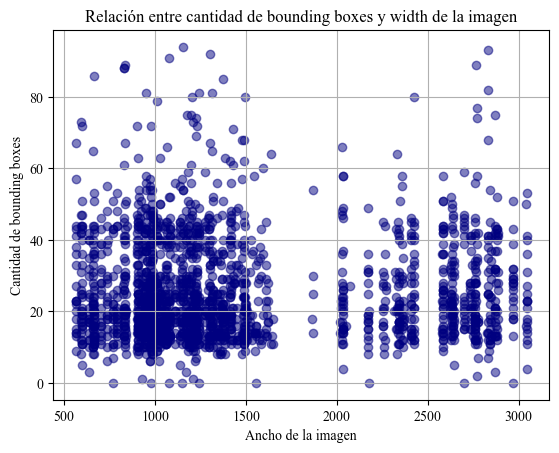

In [28]:
plt.scatter(width_list, bounding_box_counts, color='navy', alpha=0.5)
plt.title('Relación entre cantidad de bounding boxes y width de la imagen')
plt.xlabel('Ancho de la imagen')
plt.ylabel('Cantidad de bounding boxes')
plt.grid(True)
plt.show()

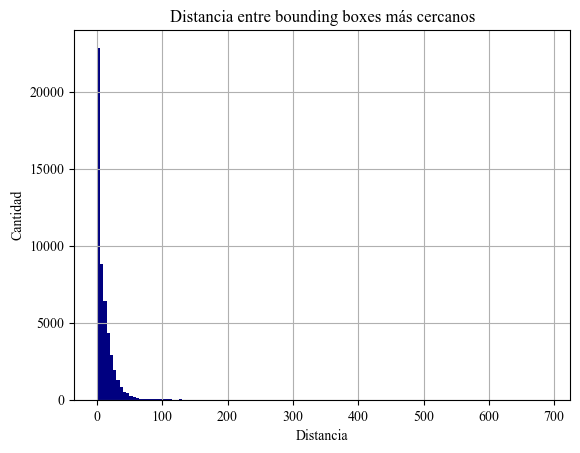

In [29]:
distance_between_bounding_boxes = []
for item in data:
    annotations = item.get('annotations', [])
    if len(annotations) < 2:
        continue  
    for i in range(len(annotations)):
        box_a = annotations[i].get('bounding_box', {})
        x1, y1, w1, h1 = box_a.get('x', 0), box_a.get('y', 0), box_a.get('w', 0), box_a.get('h', 0)
        box1 = box(x1, y1, x1 + w1, y1 + h1)
        min_distance = float('inf')
        for j in range(len(annotations)):
            if i != j:
                box_b = annotations[j].get('bounding_box', {})
                x2, y2, w2, h2 = box_b.get('x', 0), box_b.get('y', 0), box_b.get('w', 0), box_b.get('h', 0)
                box2 = box(x2, y2, x2 + w2, y2 + h2)
                distance = box1.distance(box2)
                min_distance = min(min_distance, distance)
        distance_between_bounding_boxes.append(min_distance)

plt.hist(distance_between_bounding_boxes, bins=np.arange(0, int(max(distance_between_bounding_boxes)) + 5, 5), color='navy')
plt.title('Distancia entre bounding boxes más cercanos')
plt.xlabel('Distancia')
plt.ylabel('Cantidad')
plt.grid(True)
plt.show()

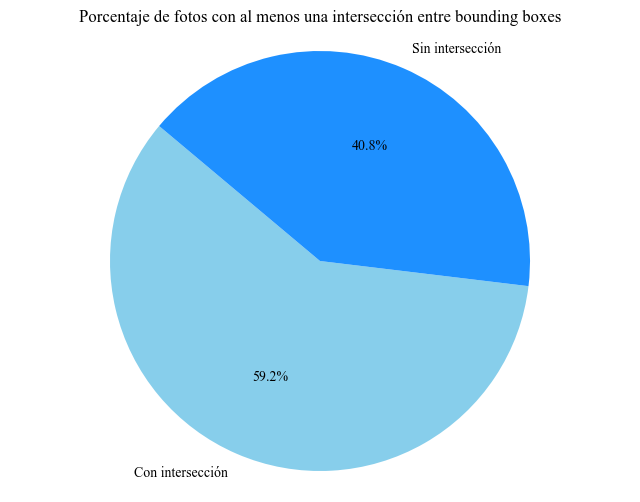

In [30]:
fotos_con_interseccion = 0
total_fotos = len(data)

for item in data:
    annotations = item.get('annotations', [])
    if len(annotations) < 2:
        continue  
    for a, b in combinations(annotations, 2):
        box_a = a.get('bounding_box', {})
        box_b = b.get('bounding_box', {})
        x1a, y1a, w1a, h1a = box_a.get('x', 0), box_a.get('y', 0), box_a.get('w', 0), box_a.get('h', 0)
        x1b, y1b, w1b, h1b = box_b.get('x', 0), box_b.get('y', 0), box_b.get('w', 0), box_b.get('h', 0)
        box1 = box(x1a, y1a, x1a + w1a, y1a + h1a)
        box2 = box(x1b, y1b, x1b + w1b, y1b + h1b)
        intersection = box1.intersection(box2)
        if intersection.area > 0:
            fotos_con_interseccion += 1
            break  

fotos_sin_interseccion = total_fotos - fotos_con_interseccion

sizes = [fotos_con_interseccion, fotos_sin_interseccion]
labels = ['Con intersección', 'Sin intersección']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'dodgerblue'])
plt.title('Porcentaje de fotos con al menos una intersección entre bounding boxes')
plt.axis('equal') 
plt.show()

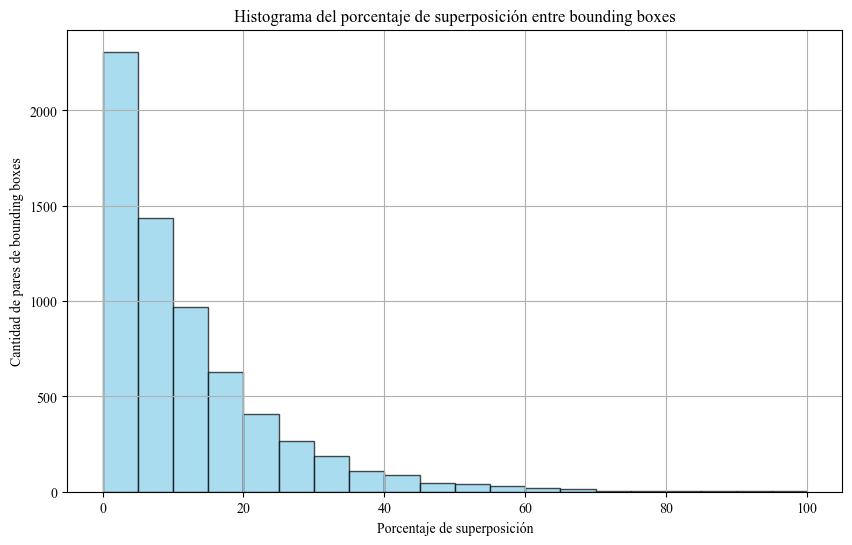

In [31]:
porcentajes_superposicion = []

for item in data:
    annotations = item.get('annotations', [])
    if len(annotations) < 2:
        continue  
    for a, b in combinations(annotations, 2):
        box_a = a.get('bounding_box', {})
        box_b = b.get('bounding_box', {})
        x1a, y1a, w1a, h1a = box_a.get('x', 0), box_a.get('y', 0), box_a.get('w', 0), box_a.get('h', 0)
        x1b, y1b, w1b, h1b = box_b.get('x', 0), box_b.get('y', 0), box_b.get('w', 0), box_b.get('h', 0)
        box1 = box(x1a, y1a, x1a + w1a, y1a + h1a)
        box2 = box(x1b, y1b, x1b + w1b, y1b + h1b)
        intersection = box1.intersection(box2)
        if intersection.area > 0:
            porcentaje_superposicion = (intersection.area / box1.area) * 100
            porcentajes_superposicion.append(porcentaje_superposicion)

plt.figure(figsize=(10, 6))
plt.hist(porcentajes_superposicion, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histograma del porcentaje de superposición entre bounding boxes')
plt.xlabel('Porcentaje de superposición')
plt.ylabel('Cantidad de pares de bounding boxes')
plt.grid(True)
plt.show()

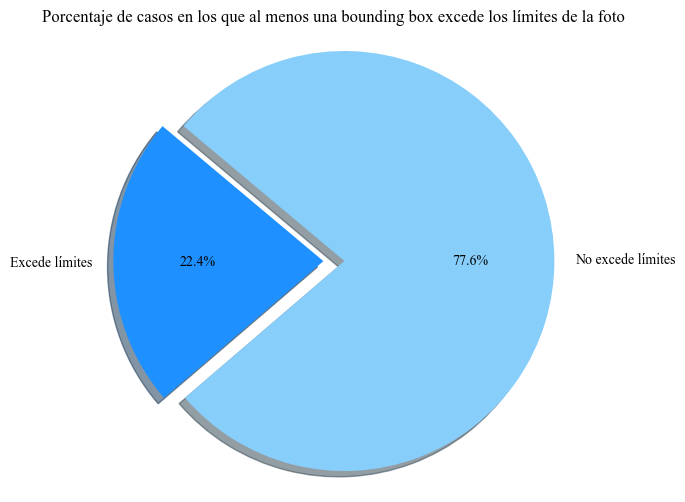

In [32]:
excede_limites = 0
total = 0

for item in data:
    total += 1
    annotations = item.get('annotations', [])
    width_img = item['item']['slots'][0]['width']
    height_img = item['item']['slots'][0]['height']
    excede = False
    for annotation in annotations:
        box_info = annotation.get('bounding_box', {})
        x, y, w, h = box_info.get('x', 0), box_info.get('y', 0), box_info.get('w', 0), box_info.get('h', 0)
        if x < 0 or y < 0 or x + w > width_img or y + h > height_img:
            excede = True
            break  
    if excede:
        excede_limites += 1

no_excede_limites = total - excede_limites

labels = ['Excede límites', 'No excede límites']
sizes = [excede_limites, no_excede_limites]
colors = ['dodgerblue', 'lightskyblue']
explode = (0.1, 0) 

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  
plt.title('Porcentaje de casos en los que al menos una bounding box excede los límites de la foto')
plt.show()

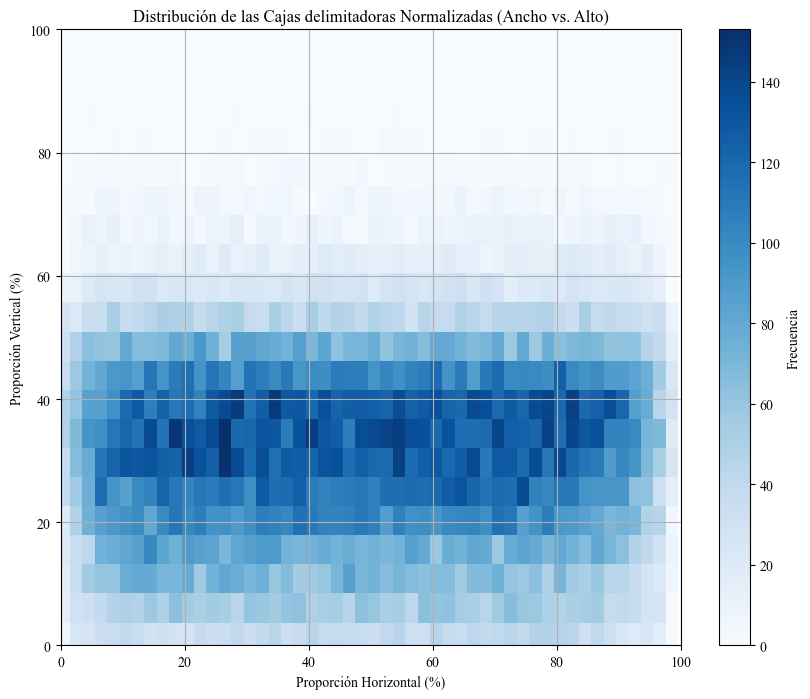

In [33]:
x_ratios = []
y_ratios = []
width_ratios = []
height_ratios = []

for item in data:
    image_width = item['item']['slots'][0]['width']
    image_height = item['item']['slots'][0]['height']
    annotations = item.get('annotations', [])
    for annotation in annotations:
        bounding_box = annotation.get('bounding_box', {})
        x_ratio = bounding_box.get('x', 0) / image_width * 100
        y_ratio = bounding_box.get('y', 0) / image_height * 100
        width_ratio = bounding_box.get('w', 0) / image_width * 100
        height_ratio = bounding_box.get('h', 0) / image_height * 100
        x_ratios.append(x_ratio)
        y_ratios.append(y_ratio)
        width_ratios.append(width_ratio)
        height_ratios.append(height_ratio)

plt.figure(figsize=(10, 8))
plt.hist2d(x_ratios, y_ratios, bins=50, cmap='Blues')
plt.colorbar(label='Frecuencia')
plt.title('Distribución de las Cajas delimitadoras Normalizadas (Ancho vs. Alto)')
plt.xlabel('Proporción Horizontal (%)')
plt.ylabel('Proporción Vertical (%)')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True)
plt.show()

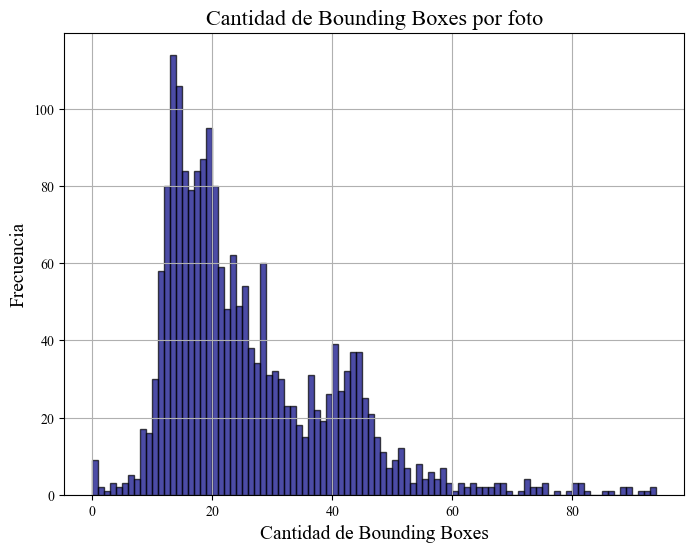

In [34]:
plt.figure(figsize=(8, 6))
plt.hist(bounding_box_counts, bins=range(min(bounding_box_counts), max(bounding_box_counts) + 1), color='navy', edgecolor='black', alpha=0.7)
plt.title('Cantidad de Bounding Boxes por foto', fontsize=16)
plt.xlabel('Cantidad de Bounding Boxes', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(True)
plt.show()

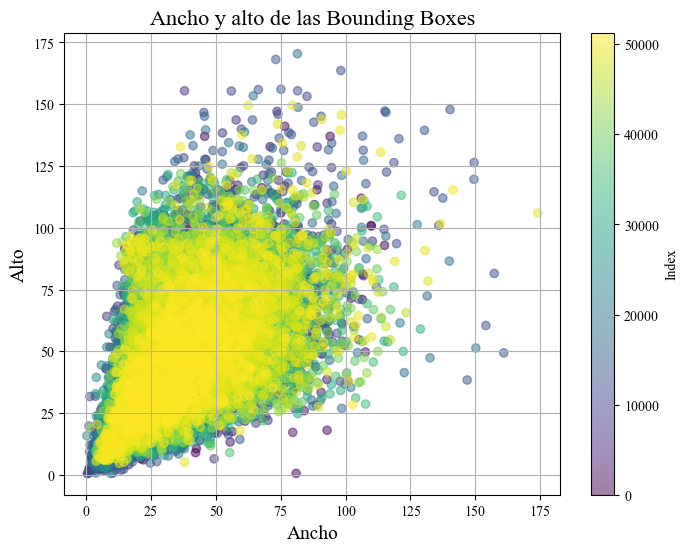

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(bounding_box_widths, bounding_box_heights, c=range(len(bounding_box_widths)), cmap='viridis', alpha=0.5)
plt.title('Ancho y alto de las Bounding Boxes', fontsize=16)
plt.xlabel('Ancho', fontsize=14)
plt.ylabel('Alto', fontsize=14)
plt.grid(True)
plt.colorbar(label='Index')
plt.show()

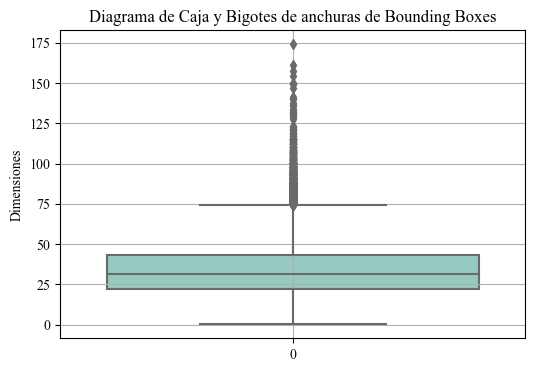

In [36]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=bounding_box_widths, palette='Set3')
plt.title('Diagrama de Caja y Bigotes de anchuras de Bounding Boxes')
# plt.xticks([0, 1], ['Ancho', 'Alto'])
plt.ylabel('Dimensiones')
plt.grid(True)
plt.show()

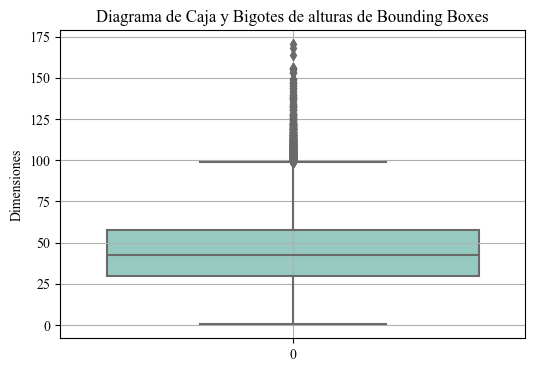

In [37]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=bounding_box_heights, palette='Set3')
plt.title('Diagrama de Caja y Bigotes de alturas de Bounding Boxes')
# plt.xticks([0, 1], ['Ancho', 'Alto'])
plt.ylabel('Dimensiones')
plt.grid(True)
plt.show()

Analizemos si existen areas de bounding boxes extremadamente grandes o pequeñas ya que seguramente sean errores

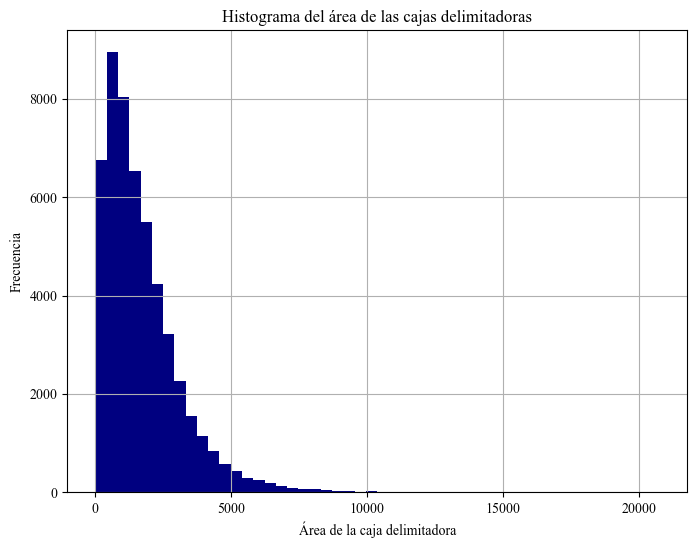

In [38]:
import matplotlib.pyplot as plt

# Calcular el área de cada caja delimitadora
bounding_box_areas = [width * height for width, height in zip(bounding_box_widths, bounding_box_heights)]

# Crear el histograma del área de las cajas delimitadoras
plt.figure(figsize=(8, 6))
plt.hist(bounding_box_areas, bins=50, color='navy')
plt.title('Histograma del área de las cajas delimitadoras')
plt.xlabel('Área de la caja delimitadora')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


Ojo! Una bounding box es grande o pequeña considerando también el tamaño de la imagen. Hagamos el mismo histograma pero poniendo en perspectiva los bounding boxes en relación a los tamaños de cada imagen

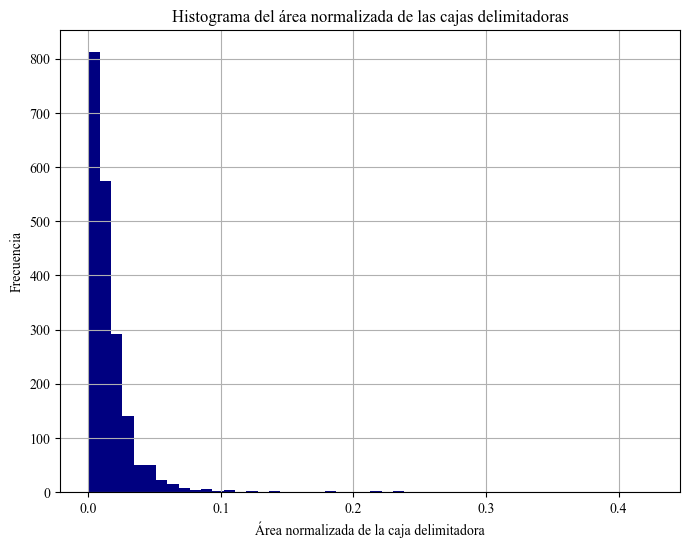

In [39]:
import matplotlib.pyplot as plt

image_areas = [item['item']['slots'][0]['width'] * item['item']['slots'][0]['height'] for item in data]

bounding_box_areas = [width * height for width, height in zip(bounding_box_widths, bounding_box_heights)]

normalized_bounding_box_areas = [area / image_area for area, image_area in zip(bounding_box_areas, image_areas)]

plt.figure(figsize=(8, 6))
plt.hist(normalized_bounding_box_areas, bins=50, color='navy')
plt.title('Histograma del área normalizada de las cajas delimitadoras')
plt.xlabel('Área normalizada de la caja delimitadora')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


Veamos cuales de ellos son outliers y de que imagenes provienen para analizar sus jason

In [40]:
import numpy as np

image_areas = [item['item']['slots'][0]['width'] * item['item']['slots'][0]['height'] for item in data]

bounding_box_areas = [width * height for width, height in zip(bounding_box_widths, bounding_box_heights)]

normalized_bounding_box_areas = [area / image_area for area, image_area in zip(bounding_box_areas, image_areas)]

Q1 = np.percentile(normalized_bounding_box_areas, 25)
Q3 = np.percentile(normalized_bounding_box_areas, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = []
for i, area in enumerate(normalized_bounding_box_areas):
    if area < lower_bound or area > upper_bound:
        item_name = data[i]['item']['name'] if i < len(data) else 'Unknown'
        outliers.append((area, item_name))

outliers_count = len(outliers)

if outliers:
    print("Outliers en el área normalizada de las cajas delimitadoras:")
    for outlier in outliers:
        print(f"Área normalizada: {outlier[0]}, Imagen: {outlier[1]}")
    print(f"Total de outliers encontrados: {outliers_count}")
else:
    print("No se encontraron outliers en el área normalizada de las cajas delimitadoras.")


Outliers en el área normalizada de las cajas delimitadoras:
Área normalizada: 0.058960007010164746, Imagen: 3709_29-6-1-4.png
Área normalizada: 0.0454906835722161, Imagen: 3227_23-5-1-3.png
Área normalizada: 0.05047311347486813, Imagen: 3157_4-4-1-2.png
Área normalizada: 0.04565364409690651, Imagen: 53994_5-2-1-1.png
Área normalizada: 0.05574591025130225, Imagen: 7298_11-5-1-5.png
Área normalizada: 0.05038198009429021, Imagen: 37420_4-5-1-1.png
Área normalizada: 0.07306061802291422, Imagen: 54120_16-31-1-1.png
Área normalizada: 0.047507675270465975, Imagen: 53823_3-6-1-1.png
Área normalizada: 0.04254024162594123, Imagen: 3152_32-6-1-2.png
Área normalizada: 0.0740209675413506, Imagen: 53808_6-4-1-1.png
Área normalizada: 0.04744109869079205, Imagen: 5256_14-4-1-1.png
Área normalizada: 0.04644225131573224, Imagen: 5255_23-3-1-2.png
Área normalizada: 0.04763061812467261, Imagen: 37420_9-1-1-3.png
Área normalizada: 0.05492210692236963, Imagen: 36804_15-4-1-7.png
Área normalizada: 0.13849362

Veamos ejemplos de outliers de bounding boxes a ver si los creemos errores

In [41]:
import cv2
import numpy as np
import os

def draw_boxes(image_path, annotations):
    image = cv2.imread(image_path)
    
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
    
    for i, annotation in enumerate(annotations):
        bounding_box = annotation['bounding_box']
        x, y, w, h = int(bounding_box['x']), int(bounding_box['y']), int(bounding_box['w']), int(bounding_box['h'])
        color = colors[i % len(colors)]  # Cambiar de color para cada bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    
    cv2.imshow("Bounding Boxes", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

outliers = [
    (0.055874703636061764, "3711_12-1-1-3.png"),
    (0.0503501049544239, "5258_34-1-1-2.png"),
    (0.17594028941854375, "37420_10-5-1-4.png"),
    (0.05398887219551282, "7307_29-5-1-1.png"),
    (0.047845000217476404, "5256_14-4-1-1.png")
]

for area, image_name in outliers:
    image_path = os.path.join(directorio, image_name)
    for item in data:
        if item['item']['name'] == image_name:
            draw_boxes(image_path, item['annotations'])
            break

# Brillo

In [42]:
folder_path = "./images"

mean_hue_list = []
mean_saturation_list = []
mean_brightness_list = []
red_list = []
green_list = []
blue_list = []

for filename in os.listdir(folder_path):
    if filename.endswith((".png", ".jpg")):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        
        image_hsv = image.convert('HSV')
        
        hues = []
        for pixel in image_hsv.getdata():
            hues.append(pixel[0])  
        mean_hue = np.mean(hues)
        mean_hue_list.append(mean_hue)
        
        mean_saturation = np.mean([pixel[1] for pixel in image_hsv.getdata()])
        mean_brightness = np.mean([pixel[2] for pixel in image_hsv.getdata()])
        mean_saturation_list.append(mean_saturation)
        mean_brightness_list.append(mean_brightness)
        
        img_rgb = np.array(image.convert('RGB'))
        
        red_values = img_rgb[:, :, 0].flatten()
        green_values = img_rgb[:, :, 1].flatten()
        blue_values = img_rgb[:, :, 2].flatten()
        
        mean_red = np.mean(red_values)
        mean_green = np.mean(green_values)
        mean_blue = np.mean(blue_values)
        red_list.append(mean_red)
        green_list.append(mean_green)
        blue_list.append(mean_blue)

data = {
    'mean_hue': mean_hue_list,
    'mean_saturation': mean_saturation_list,
    'mean_brightness': mean_brightness_list,
    'red': red_list,
    'green': green_list,
    'blue': blue_list
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de correlación entre las características de las imágenes')
plt.show()

: 

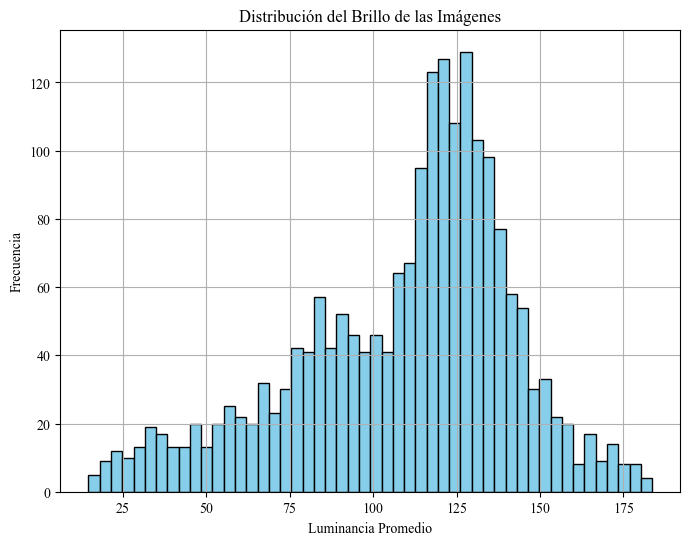

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(mean_brightness_list, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución del Brillo promedio de las Imágenes')
plt.xlabel('Luminancia Promedio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Hue

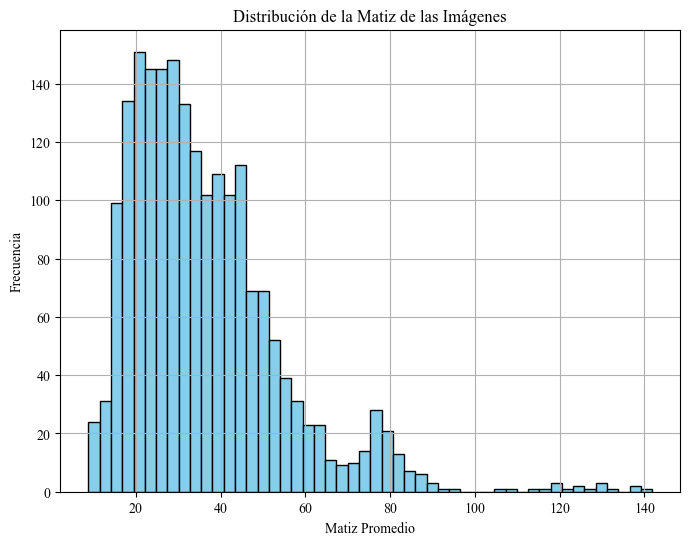

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(mean_hue_list, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de la Matiz de las Imágenes')
plt.xlabel('Matiz Promedio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Saturacion

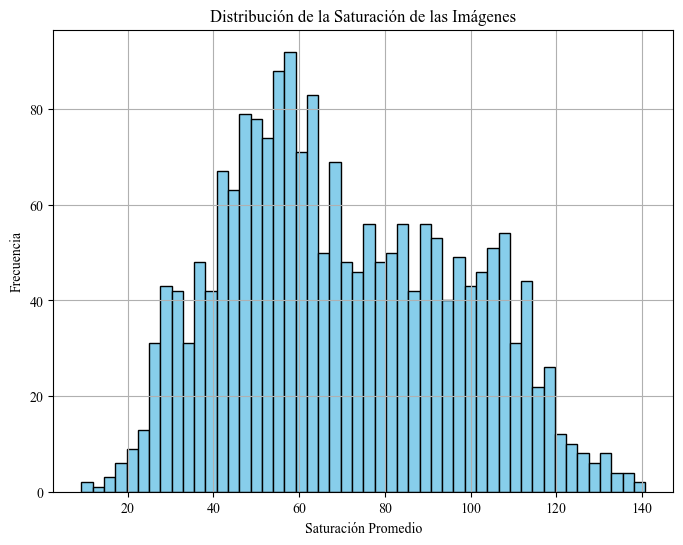

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(mean_saturation_list, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de la Saturación de las Imágenes')
plt.xlabel('Saturación Promedio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

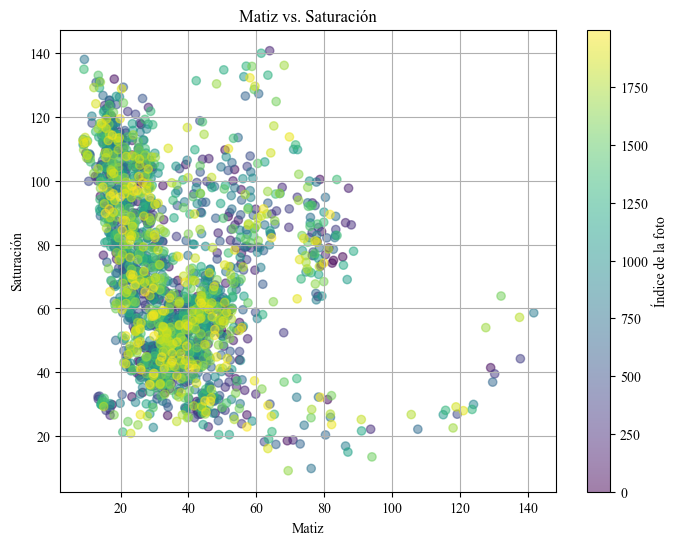

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(hue_values, saturation_values, c=range(len(saturation_values)), cmap='viridis', alpha=0.5)
plt.title('Matiz vs. Saturación')
plt.xlabel('Matiz')
plt.ylabel('Saturación')
plt.colorbar(label='Índice de la foto')  # Agregar la barra de colores para el índice de la foto
plt.grid(True)
plt.show()

# RGB

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

images_dir = "./images"
image_files = [f for f in os.listdir(images_dir) if f.endswith((".png", ".jpg"))]
num_images = len(image_files)
image_size = (100, 100)

rgb_values = []

for filename in image_files:
    image_path = os.path.join(images_dir, filename)
    img = Image.open(image_path)
    img = img.resize(image_size)
    img_rgb = np.array(img.convert('RGB'))
    for row in img_rgb:
        for pixel in row:
            rgb_values.append(pixel)

rgb_values = np.array(rgb_values)

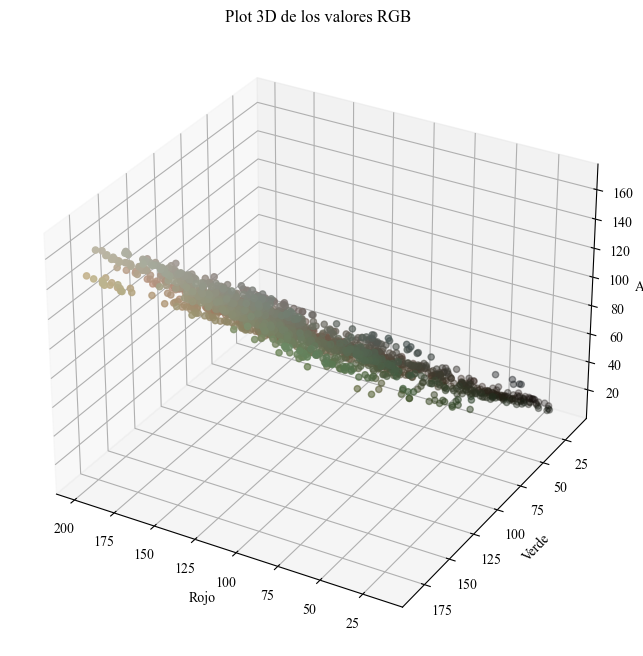

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['red'], df['green'], df['blue'], c=df[['red', 'green', 'blue']] / 255, marker='o')

ax.set_xlabel('Rojo')
ax.set_ylabel('Verde')
ax.set_zlabel('Azul')

plt.title('Plot 3D de los valores RGB')

ax.view_init(30, 120)  

plt.show()

# Texture Analysis 

/Users/azulmakk/anaconda3/lib/python3.11/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


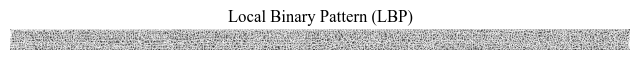

In [ ]:
images = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        images.append(image)

rgb_images = [rgba2rgb(np.array(image)) for image in images]

gray_images = [rgb2gray(image) for image in rgb_images]

radius = 3
n_points = 8 * radius

lbp_image = local_binary_pattern(gray_images[0], n_points, radius, method='uniform')

lbp_image = (lbp_image - np.min(lbp_image)) / (np.max(lbp_image) - np.min(lbp_image)) * 255

plt.figure(figsize=(8, 4))
plt.imshow(lbp_image, cmap='gray')
plt.title('Local Binary Pattern (LBP)')
plt.axis('off')
plt.show()

Patrones LBP: Cada valor en la imagen representa un patrón LBP calculado para cada píxel de la imagen original. Los patrones LBP capturan la información sobre la textura local alrededor de cada píxel. Cada píxel en la imagen LBP se calcula comparando el valor del píxel central con los valores de los píxeles circundantes en una vecindad definida por el radio y el número de puntos.

Escala de grises: La imagen LBP se muestra en escala de grises, donde los valores más bajos corresponden a áreas con texturas más suaves o uniformes, mientras que los valores más altos representan áreas con texturas más variadas o complejas.

Rango de valores: Los valores en la imagen LBP están normalizados para que se ajusten al rango [0, 255], lo que permite una mejor visualización y comparación entre diferentes imágenes y diferentes partes de la misma imagen.

Interpretación: Las regiones más oscuras en la imagen LBP indican áreas con texturas más simples y uniformes, mientras que las regiones más claras indican áreas con texturas más complejas o variadas. Al observar la distribución de los valores LBP en la imagen, se pueden identificar diferentes tipos de texturas presentes en la imagen original.